# Sentiment Analysis

---
In this notebook we will build an end-to-end sentiment classification system from scratch.

The dataset we are going to use is very popular among researchers in Natural Language Processing, usually referred to as the [IMDb dataset](http://ai.stanford.edu/~amaas/data/sentiment/). It consists of movie reviews from the website [imdb.com](http://www.imdb.com/), each labeled as either '**pos**itive', if the reviewer enjoyed the film, or '**neg**ative' otherwise.

> Maas, Andrew L., et al. [Learning Word Vectors for Sentiment Analysis](http://ai.stanford.edu/~amaas/data/sentiment/). In _Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies_. Association for Computational Linguistics, 2011.

## Step 1: Exploring the data!

Load the dataset.

In [2]:
import os
import glob

def read_imdb_data(data_dir='data/imdb-reviews'):
    """Read IMDb movie reviews from given directory.
    
    Directory structure expected:
    - data/
        - train/
            - pos/
            - neg/
        - test/
            - pos/
            - neg/
    
    """

    # Data, labels to be returned in nested dicts matching the dir. structure
    data = {}
    labels = {}

    # Assume 2 sub-directories: train, test
    for data_type in ['train', 'test']:
        data[data_type] = {}
        labels[data_type] = {}

        # Assume 2 sub-directories for sentiment (label): pos, neg
        for sentiment in ['pos', 'neg']:
            data[data_type][sentiment] = []
            labels[data_type][sentiment] = []
            
            # Fetch list of files for this sentiment
            path = os.path.join(data_dir, data_type, sentiment, '*.txt')
            files = glob.glob(path)
            
            # Read reviews data and assign labels
            for f in files:
                with open(f) as review:
                    data[data_type][sentiment].append(review.read())
                    labels[data_type][sentiment].append(sentiment)
            
            assert len(data[data_type][sentiment]) == len(labels[data_type][sentiment]), \
                    "{}/{} data size does not match labels size".format(data_type, sentiment)
    
    # Return data, labels as nested dicts
    return data, labels


data, labels = read_imdb_data()
print("IMDb reviews: train = {} pos / {} neg, test = {} pos / {} neg".format(
        len(data['train']['pos']), len(data['train']['neg']),
        len(data['test']['pos']), len(data['test']['neg'])))

IMDb reviews: train = 12500 pos / 12500 neg, test = 12500 pos / 12500 neg


Now that the data is loaded in, let's take a quick look at one of the positive reviews:

In [3]:
print(data['train']['pos'][2])

A solid, if unremarkable film. Matthau, as Einstein, was wonderful. My favorite part, and the only thing that would make me go out of my way to see this again, was the wonderful scene with the physicists playing badmitton, I loved the sweaters and the conversation while they waited for Robbins to retrieve the birdie.


And one with a negative sentiment:

In [4]:
print(data['train']['neg'][2])

Ouch! This one was a bit painful to sit through. It has a cute and amusing premise, but it all goes to hell from there. Matthew Modine is almost always pedestrian and annoying, and he does not disappoint in this one. Deborah Kara Unger and John Neville turned in surprisingly decent performances. Alan Bates and Jennifer Tilly, among others, played it way over the top. I know that's the way the parts were written, and it's hard to blame actors, when the script and director have them do such schlock. If you're going to have outrageous characters, that's OK, but you gotta have good material to make it work. It didn't here. Run away screaming from this movie if at all possible.


We can also make a wordcloud visualization of the reviews.

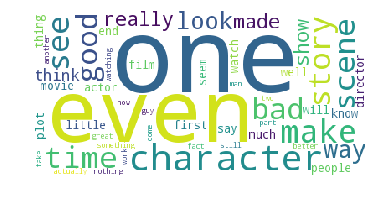

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS

sentiment = 'neg'

# Combine all reviews for the desired sentiment
combined_text = " ".join([review for review in data['train'][sentiment]])

# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50,
        # update stopwords to include common words like film and movie
        stopwords = STOPWORDS.update(['br','film','movie']))

# Generate and plot wordcloud
plt.imshow(wc.generate(combined_text))
plt.axis('off')
plt.show()

Try changing the sentiment to `'neg'` and see if you can spot any obvious differences between the wordclouds.

### Form training and test sets

Now that you've seen what the raw data looks like, we'll combine the positive and negative documents to get one unified training set and one unified test set.

In [6]:
from sklearn.utils import shuffle

def prepare_imdb_data(data):
    """Prepare training and test sets from IMDb movie reviews."""
    
    # Combine positive and negative reviews and labels
    data_train = data['train']['pos'] + (data['train']['neg'])
    data_test = data['test']['pos'] + (data['test']['neg'])
    
    labels_train = labels['train']['pos'] + (labels['train']['neg'])
    labels_test = labels['test']['pos'] + (labels['test']['neg'])
    
    # Shuffle reviews and corresponding labels within training and test sets
    data_train = shuffle(data_train)
    data_test = shuffle(data_test)
    labels_train = shuffle(labels_train)
    labels_test = shuffle(labels_test)
    # Return a unified training data, test data, training labels, test labets
    return data_train, data_test, labels_train, labels_test


data_train, data_test, labels_train, labels_test = prepare_imdb_data(data)
print("IMDb reviews (combined): train = {}, test = {}".format(len(data_train), len(data_test)))

IMDb reviews (combined): train = 25000, test = 25000


## Step 2. Preprocessing

Our raw data includes HTML tags, they need to be removed. We also need to remove non-letter characters, normalize uppercase letters by converting them to lowercase, tokenize, remove stop words, and stem the remaining words in each document.

### Convert each review to words

As your next task, you should complete the function `review_to_words()` that performs all these steps. For your convenience, in the Python cell below we provide you with all the libraries that you may need in order to accomplish these preprocessing steps. Make sure you can import all of them! (If not, pip install from a terminal and run/import again.)

In [1]:
# BeautifulSoup to easily remove HTML tags
from bs4 import BeautifulSoup 

# RegEx for removing non-letter characters
import re

# NLTK library for the remaining steps
import nltk
nltk.download("stopwords")   # download list of stopwords (only once; need not run it again)
from nltk.corpus import stopwords # import stopwords

from nltk.stem.porter import *
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lkronecker/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
def review_to_words(review):
    """Convert a raw review string into a sequence of words."""
    words = []
    # Remove HTML tags and non-letters, convert to lowercase, tokenize, remove stopwords and stem
    clean_review = re.compile(r'<.*?>').sub('', review)
    clean_review = clean_review.lower()
    clean_review = re.sub(r"[^a-zA-Z0-9]", " ", clean_review)
    words = clean_review.split()
    words = [w for w in words if w not in stopwords.words("english")]
    words = [PorterStemmer().stem(w) for w in words]

    return words


review_to_words("""This is just a <em>test</em>.<br/><br />
But if it wasn't a test, it would make for a <b>Great</b> movie review!""")

['test', 'test', 'would', 'make', 'great', 'movi', 'review']

With the function `review_to_words()` fully implemeneted, we can apply it to all reviews in both training and test datasets. This may take a while, so let's build in a mechanism to write to a cache file and retrieve from it later.

In [8]:
import pickle

cache_dir = os.path.join("cache", "sentiment_analysis")  # where to store cache files
os.makedirs(cache_dir, exist_ok=True)  # ensure cache directory exists

def preprocess_data(data_train, data_test, labels_train, labels_test,
                    cache_dir=cache_dir, cache_file="preprocessed_data.pkl"):
    """Convert each review to words; read from cache if available."""

    # If cache_file is not None, try to read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = pickle.load(f)
            print("Read preprocessed data from cache file:", cache_file)
        except:
            pass  # unable to read from cache, but that's okay
    
    # If cache is missing, then do the heavy lifting
    if cache_data is None:
        # Preprocess training and test data to obtain words for each review
        words_train = list(map(review_to_words, data_train))
        words_test = list(map(review_to_words, data_test))
        
        # Write to cache file for future runs
        if cache_file is not None:
            cache_data = dict(words_train=words_train, words_test=words_test,
                              labels_train=labels_train, labels_test=labels_test)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                pickle.dump(cache_data, f)
            print("Wrote preprocessed data to cache file:", cache_file)
    else:
        # Unpack data loaded from cache file
        words_train, words_test, labels_train, labels_test = (cache_data['words_train'],
                cache_data['words_test'], cache_data['labels_train'], cache_data['labels_test'])
    
    return words_train, words_test, labels_train, labels_test


# Preprocess data
words_train, words_test, labels_train, labels_test = preprocess_data(
        data_train, data_test, labels_train, labels_test)

# Take a look at a sample
print("\n--- Raw review ---")
print(data_train[1])
print("\n--- Preprocessed words ---")
print(words_train[1])
print("\n--- Label ---")
print(labels_train[1])

Read preprocessed data from cache file: preprocessed_data.pkl

--- Raw review ---
Fay Grim is a true example of what I call a completed puzzle film. It has all the pieces of acting, direction, storyline, and entertainment value. They all fit together and when done so create a masterpiece, Fay Grim.<br /><br />This film follows a single mother Fay Grim trying to raise her son to not grow up to be her father who ran away from the law and went missing. Soon the CIA contacts Fay in desperate pursuit to find 8 journals of her husband Henry's. These journals were filled with confessions of his long past in the CIA and his involvement with countries and their government doings. Fay is sent to find these journals, in return to release her brother from prison, and is sent on a cat-and-mouse chase all over Europe to recover these journals and learn of the hidden secrets of her husbands past she never knew about.<br /><br />Parker Posey had already been an actress I liked after I watched her in T

## Step 3: Extracting Bag-of-Words features

Now that each document has been preprocessed, we can transform each into a Bag-of-Words feature representation. Note that we need to create this transformation based on the training data alone, as we are not allowed to peek at the testing data at all!

The dictionary or _vocabulary_ $V$ (set of words shared by documents in the training set) used here will be the one on which we train our supervised learning algorithm. Any future test data must be transformed in the same way for us to be able to apply the learned model for prediction. Hence, it is important to store the transformation / vocabulary as well.

> **Note**: The set of words in the training set may not be exactly the same as the test set. What do you do if you encounter a word during testing that you haven't seen before? Unfortunately, we'll have to ignore it, or replace it with a special `<UNK>` token.

### Compute Bag-of-Words features

Let's implement the `extract_BoW_features()` function, apply it to both training and test datasets, and store the results in `features_train` and `features_test` NumPy arrays, respectively. Choose a reasonable vocabulary size, say $|V| = 5000$, and keep only the top $|V|$ occuring words and discard the rest. This number will also serve as the number of columns in the BoW matrices.

> **Note**: Take advantage of `CountVectorizer` from scikit-learn. Also make sure to pickle your Bag-of-Words transformation so that you can use it in future.

In [9]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.externals import joblib
# joblib is an enhanced version of pickle that is more efficient for storing NumPy arrays

def extract_BoW_features(words_train, words_test, vocabulary_size=5000,
                         cache_dir=cache_dir, cache_file="bow_features.pkl"):
    """Extract Bag-of-Words for a given set of documents, already preprocessed into words."""
    
    # If cache_file is not None, try to read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = joblib.load(f)
            print("Read features from cache file:", cache_file)
        except:
            pass  # unable to read from cache, but that's okay
    
    # If cache is missing, then do the heavy lifting
    if cache_data is None:
        # Fit a vectorizer to training documents and use it to transform them
        # NOTE: Training documents have already been preprocessed and tokenized into words;
        #       pass in dummy functions to skip those steps, e.g. preprocessor=lambda x: x
        vectorizer = CountVectorizer(preprocessor=lambda x: x, tokenizer=lambda x: x, max_features = vocabulary_size,
                                     vocabulary = None)
        
        features_train = vectorizer.fit_transform(words_train).toarray()

        # Apply the same vectorizer to transform the test documents (ignore unknown words)
        features_test = vectorizer.fit_transform(words_test).toarray()
        
        # NOTE: Remember to convert the features using .toarray() for a compact representation
        
        # Write to cache file for future runs (store vocabulary as well)
        if cache_file is not None:
            vocabulary = vectorizer.vocabulary_
            cache_data = dict(features_train=features_train, features_test=features_test,
                             vocabulary=vocabulary)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                joblib.dump(cache_data, f)
            print("Wrote features to cache file:", cache_file)
    else:
        # Unpack data loaded from cache file
        features_train, features_test, vocabulary = (cache_data['features_train'],
                cache_data['features_test'], cache_data['vocabulary'])
    
    # Return both the extracted features as well as the vocabulary
    return features_train, features_test, vocabulary


# Extract Bag of Words features for both training and test datasets
features_train, features_test, vocabulary = extract_BoW_features(words_train, words_test)

# Inspect the vocabulary that was computed
print("Vocabulary: {} words".format(len(vocabulary)))

import random
print("Sample words: {}".format(random.sample(list(vocabulary.keys()), 8)))

Read features from cache file: bow_features.pkl
Vocabulary: 5000 words
Sample words: ['divid', 'rule', 'behav', 'despis', '1950', 'grass', 'su', 'calib']


In [10]:
# Sample
print("\n--- Preprocessed words ---")
print(words_train[6])
print("\n--- Bag-of-Words features ---")
print(features_train[6])
print("\n--- Label ---")
print(labels_train[6])


--- Preprocessed words ---
['believ', 'ever', 'evil', 'wick', 'televis', 'program', 'air', 'unit', 'state', '700', 'club', 'today', 'equival', 'ku', 'klux', 'klan', '20th', 'centuri', 'hatr', 'good', 'sweet', 'human', 'pure', 'beyond', 'abil', 'understand', 'daili', 'constant', 'attack', 'upon', 'million', 'million', 'american', 'well', 'billion', 'human', 'world', 'happen', 'share', 'bigot', 'cruel', 'monstrou', 'utterli', 'insan', 'view', 'human', 'beyond', 'anyth', 'televis', 'ever', 'seen', 'lie', 'spout', 'ridicul', 'lie', 'tri', 'pass', 'truth', 'idea', 'life', 'death', 'god', 'sin', 'devil', 'preposter', 'actual', 'seem', 'mental', 'ill', 'lost', 'fantasi', 'sane', 'peopl', 'know', 'religion', 'drug', 'let', 'get', 'addict', 'type', 'fantasi', 'howev', '700', 'club', 'class', 'truli', 'cult', 'believ', 'freedom', 'speech', 'way', 'spread', 'hatr', 'lie', 'disinform', 'fantast', 'idea', 'beyond', 'limit', 'hope', 'one', 'day', 'american', 'psychiatr', 'associ', 'final', 'take', 

Let's try to visualize the Bag-of-Words feature vector for one of our training documents.

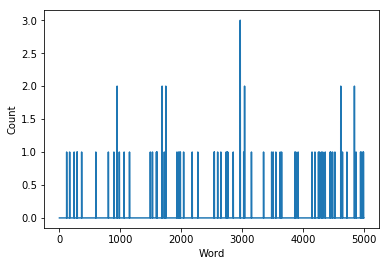

In [62]:
# Plot the BoW feature vector for a training document
plt.plot(features_train[100,:])
plt.xlabel('Word')
plt.ylabel('Count')
plt.show()

In [20]:
zero_percentage_list = []

for bow in features_train:
    zeros = 0
    non_zeros = 0
    total_sum = 0
    
    for el in bow:
        if el == 0:
            zeros += 1
        else:
            non_zeros += 1
            
    total_sum = zeros + non_zeros
    percentage_of_zeros = (zeros*100)/total_sum
    
    zero_percentage_list.append(percentage_of_zeros)
    #     print('Zeros: '+ str(zeros))
    #     print('Non zeros: '+ str(non_zeros))
    #     print('Total entries: '+ str(total_sum))
    #     print(percentage_of_zeros)
    #     print('\n')

# print(zero_percentage_list)
print('Sparcity averge in feature vectors:' + str(sum(zero_percentage_list)/len(zero_percentage_list)))

Sparcity averga in feature vectors:98.30884000000019




On average 98.3% of the entries in a BoW feature is zero. This makes our feature vectors extremely sparce.

### Zipf's law

[Zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law), named after the famous American linguist George Zipf, is an empirical law stating that given a large collection of documents, the frequency of any word is inversely proportional to its rank in the frequency table. So the most frequent word will occur about twice as often as the second most frequent word, three times as often as the third most frequent word, and so on. In the figure below we plot number of appearances of each word in our training set against its rank.

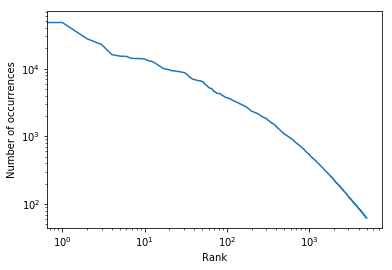

In [64]:
# Find number of occurrences for each word in the training set
word_freq = features_train.sum(axis=0)

# Sort it in descending order
sorted_word_freq = np.sort(word_freq)[::-1]

# Plot 
plt.plot(sorted_word_freq)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.xlabel('Rank')
plt.ylabel('Number of occurrences')
plt.show()

In [65]:
print(sorted_word_freq)

[51694 48190 27741 ...,    62    62    62]


In [66]:
print(max(word_freq))
print(type(max(word_freq)))

edited_word_freq = word_freq.tolist()
edited_word_freq.remove(51694)
print(max(edited_word_freq))

# print(word_freq == edited_word_freq)

51694
<class 'numpy.int64'>
48190


Most frequent word : 51694, next most freq: 48190. Does not follow Zipf's law


### Normalize feature vectors

Bag-of-Words features are intuitive to understand as they are simply word counts. But counts can vary a lot, and potentially throw off learning algorithms later in the pipeline. So, before we proceed further, let's normalize the BoW feature vectors to have unit length.

This makes sure that each document's representation retains the unique mixture of feature components, but prevents documents with large word counts from dominating those with fewer words.

In [67]:
len(features_train[100])

5000

In [21]:
import sklearn.preprocessing as pr

features_train = pr.normalize(features_train)
features_test = pr.normalize(features_test)


/Users/lkronecker/anaconda/envs/nlp-env/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


In [22]:
features_train[0]

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

## Step 4: Classification using BoW features

Now that the data has all been properly transformed, we can feed it into a classifier. To get a baseline model, we train a Naive Bayes classifier from scikit-learn (specifically, [`GaussianNB`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)), and evaluate its accuracy on the test set.

In [70]:
from sklearn.naive_bayes import GaussianNB

# Train a Guassian Naive Bayes classifier
clf1 = GaussianNB()
clf1.fit(features_train, labels_train)

# Calculate the mean accuracy score on training and test sets
print("[{}] Accuracy: train = {}, test = {}".format(
        clf1.__class__.__name__,
        clf1.score(features_train, labels_train),
        clf1.score(features_test, labels_test)))

[GaussianNB] Accuracy: train = 0.62584, test = 0.49988


Tree-based algorithms often work quite well on Bag-of-Words as their highly discontinuous and sparse nature is nicely matched by the structure of trees. As your next task, you will try to improve on the Naive Bayes classifier's performance by using scikit-learn's Gradient-Boosted Decision Tree classifer.

### Gradient-Boosted Decision Tree classifier

Let's use [`GradientBoostingClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) from scikit-learn to classify the BoW data. This model has a number of parameters. We use default parameters for some of them and pre-set the rest for you, except one: `n_estimators`. Find a proper value for this hyperparameter, use it to classify the data, and report how much improvement you get over Naive Bayes in terms of accuracy.

> **Note**: Use a model selection technique such as cross-validation, grid-search, or an information criterion method, to find an optimal value for the hyperparameter.

In [81]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

n_estimators = 100

def classify_gboost(X_train, X_test, y_train, y_test):        
    # Initialize classifier
    clf = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=1.0, max_depth=1, random_state=0)

    # Classify the data using GradientBoostingClassifier
    clf.fit(features_train, labels_train)

    # Perform hyperparameter tuning / model selection
#     scores = cross_val_score(clf, features_train, labels_train, cv=3)
    
#     print(scores)
#     print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    
    # TODO: Print final training & test accuracy
    print("[{}] Accuracy: train = {}, test = {}".format(
        clf.__class__.__name__,
        clf.score(features_train, labels_train),
        clf.score(features_test, labels_test)))
    
    # Return best classifier model
    return clf


clf2 = classify_gboost(features_train, features_test, labels_train, labels_test)

[GradientBoostingClassifier] Accuracy: train = 0.5628, test = 0.50364


In [82]:
clf2

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=1.0, loss='deviance', max_depth=1,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False)

###  Adverserial testing

Lets write a short movie review to trick your machine learning model! That is, a movie review with a clear positive or negative sentiment that your model will classify incorrectly.



In [101]:
my_review = "This was a very bad movie"
true_sentiment = 'neg'  # sentiment must be 'pos' or 'neg'

# Apply the same preprocessing and vectorizing steps as you did for your training data
processed_words = review_to_words(my_review)
print(processed_words)

vectorizer = CountVectorizer(preprocessor=lambda x: x, tokenizer=lambda x: x, max_features = 5000,
                                     vocabulary = vocabulary) #words_train
        
processed_words = vectorizer.fit_transform(processed_words).toarray()
print(processed_words)

# Then call your classifier to label it
predictions = clf2.predict(processed_words)

['bad', 'movi']
[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


In [107]:
print(len(processed_words[0]))
print(predictions)

5000
['pos' 'pos']


## Step 5: Switching gears - RNNs

We just saw how the task of sentiment analysis can be solved via a traditional machine learning approach: BoW + a nonlinear classifier. We now switch gears and use Recurrent Neural Networks, and in particular LSTMs, to perform sentiment analysis in Keras. Conveniently, Keras has a built-in [IMDb movie reviews dataset](https://keras.io/datasets/#imdb-movie-reviews-sentiment-classification) that we can use, with the same vocabulary size.

In [108]:
from keras.datasets import imdb  # import the built-in imdb dataset in Keras

# Set the vocabulary size
vocabulary_size = 5000

# Load in training and test data (note the difference in convention compared to scikit-learn)
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=vocabulary_size)
print("Loaded dataset with {} training samples, {} test samples".format(len(X_train), len(X_test)))

Using TensorFlow backend.


Loaded dataset with 25000 training samples, 25000 test samples


In [109]:
# Inspect a sample review and its label
print("--- Review ---")
print(X_train[7])
print("--- Label ---")
print(y_train[7])

--- Review ---
[1, 4, 2, 716, 4, 65, 7, 4, 689, 4367, 2, 2343, 4804, 2, 2, 2, 2, 2315, 2, 2, 2, 2, 4, 2, 628, 2, 37, 9, 150, 4, 2, 4069, 11, 2909, 4, 2, 847, 313, 6, 176, 2, 9, 2, 138, 9, 4434, 19, 4, 96, 183, 26, 4, 192, 15, 27, 2, 799, 2, 2, 588, 84, 11, 4, 3231, 152, 339, 2, 42, 4869, 2, 2, 345, 4804, 2, 142, 43, 218, 208, 54, 29, 853, 659, 46, 4, 882, 183, 80, 115, 30, 4, 172, 174, 10, 10, 1001, 398, 1001, 1055, 526, 34, 3717, 2, 2, 2, 17, 4, 2, 1094, 871, 64, 85, 22, 2030, 1109, 38, 230, 9, 4, 4324, 2, 251, 2, 1034, 195, 301, 14, 16, 31, 7, 4, 2, 8, 783, 2, 33, 4, 2945, 103, 465, 2, 42, 845, 45, 446, 11, 1895, 19, 184, 76, 32, 4, 2, 207, 110, 13, 197, 4, 2, 16, 601, 964, 2152, 595, 13, 258, 4, 1730, 66, 338, 55, 2, 4, 550, 728, 65, 1196, 8, 1839, 61, 1546, 42, 2, 61, 602, 120, 45, 2, 6, 320, 786, 99, 196, 2, 786, 2, 4, 225, 4, 373, 1009, 33, 4, 130, 63, 69, 72, 1104, 46, 1292, 225, 14, 66, 194, 2, 1703, 56, 8, 803, 1004, 6, 2, 155, 11, 4, 2, 3231, 45, 853, 2029, 8, 30, 6, 117, 430

Notice that the label is an integer (0 for negative, 1 for positive), and the review itself is stored as a sequence of integers. These are word IDs that have been preassigned to individual words. To map them back to the original words, you can use the dictionary returned by `imdb.get_word_index()`.

In [110]:
# Map word IDs back to words
word2id = imdb.get_word_index()
id2word = {i: word for word, i in word2id.items()}
print("--- Review (with words) ---")
print([id2word.get(i, " ") for i in X_train[7]])
print("--- Label ---")
print(y_train[7])

1646592/1641221 [==============================] - 0s 0us/step
--- Review (with words) ---
['the', 'of', 'and', 'local', 'of', 'their', 'br', 'of', 'attention', 'widow', 'and', 'captures', 'parties', 'and', 'and', 'and', 'and', 'excitement', 'and', 'and', 'and', 'and', 'of', 'and', 'english', 'and', 'like', 'it', 'years', 'of', 'and', 'unintentional', 'this', 'hitchcock', 'of', 'and', 'learn', 'everyone', 'is', 'quite', 'and', 'it', 'and', 'such', 'it', 'bonus', 'film', 'of', 'too', 'seems', 'he', 'of', 'enough', 'for', 'be', 'and', 'editing', 'and', 'and', 'please', 'great', 'this', 'of', 'shoots', 'thing', '3', 'and', "it's", 'mentioning', 'and', 'and', 'given', 'parties', 'and', 'back', 'out', 'interesting', 'times', 'no', 'all', 'average', 'talking', 'some', 'of', 'nor', 'seems', 'into', 'best', 'at', 'of', 'every', 'cast', 'i', 'i', 'inside', 'keep', 'inside', 'large', 'viewer', 'who', 'obscure', 'and', 'and', 'and', 'movie', 'of', 'and', 'entirely', "you've", 'see', 'because', 'y

Unlike our Bag-of-Words approach, where we simply summarized the counts of each word in a document, this representation essentially retains the entire sequence of words (minus punctuation, stopwords, etc.). This is critical for RNNs to function. But it also means that now the features can be of different lengths!


###  Pad sequences

In order to feed this data into your RNN, all input documents must have the same length. Let's limit the maximum review length to `max_words` by truncating longer reviews and padding shorter reviews with a null value (0). You can accomplish this easily using the [`pad_sequences()`](https://keras.io/preprocessing/sequence/#pad_sequences) function in Keras. For now, set `max_words` to 500.

In [111]:
from keras.preprocessing import sequence

# Set the maximum number of words per document (for both training and testing)
max_words = 500

# Pad sequences in X_train and X_test
X_train = sequence.pad_sequences(X_train, max_words)
X_test = sequence.pad_sequences(X_test, max_words)

print(len(X_train[0]))
print(len(X_test[0]))

500
500


In [127]:
print(X_train)
print(len(X_train))

[[   0    0    0 ...,   19  178   32]
 [   0    0    0 ...,   16  145   95]
 [   0    0    0 ...,    7  129  113]
 ..., 
 [   0    0    0 ...,    4 3586    2]
 [   0    0    0 ...,   12    9   23]
 [   0    0    0 ...,  204  131    9]]
25000


In [118]:
maxes_list = []
for word in X_train:
    maxes_list.append(max(word))


In [120]:
vocabulary_size = max(maxes_list)
print(vocabulary_size)

4999


### Design an RNN model for sentiment analysis

Now lets build the model architecture. Our input is a sequence of words (technically, integer word IDs) of maximum length = `max_words`, and our output is a binary sentiment label (0 or 1).

In [138]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

# Design your model
model = Sequential()
model.add(Embedding(vocabulary_size, 111, input_length=max_words))
model.add(LSTM(11, activation='tanh'))
model.add(Dropout(.5))
model.add(Dense(1, activation='softmax'))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 111)          555000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 11)                5412      
_________________________________________________________________
dropout_2 (Dropout)          (None, 11)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 12        
Total params: 560,424
Trainable params: 560,424
Non-trainable params: 0
_________________________________________________________________
None


### Train and evaluate model

Now you are ready to train your model. In Keras world, you first need to _compile_ your model by specifying the loss function and optimizer you want to use while training, as well as any evaluation metrics you'd like to measure. Specify the approprate parameters, including at least one metric `'accuracy'`.

In [139]:
from keras.optimizers import RMSprop
# Compile your model, specifying a loss function, optimizer, and metrics

optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])

Once compiled, you can kick off the training process. There are two important training parameters that you have to specify - **batch size** and **number of training epochs**, which together with your model architecture determine the total training time.

Training may take a while, so grab a cup of coffee, or better, go for a hike! If possible, consider using a GPU, as a single training run can take several hours on a CPU.

> **Tip**: You can split off a small portion of the training set to be used for validation during training. This will help monitor the training process and identify potential overfitting. You can supply a validation set to `model.fit()` using its `validation_data` parameter, or just specify `validation_split` - a fraction of the training data for Keras to set aside for this purpose (typically 5-10%). Validation metrics are evaluated once at the end of each epoch.

In [143]:
print(X_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(10240, 500)
(2048, 500)
(20000,)
(4000,)


In [142]:
# Specify training parameters: batch size and number of epochs
batch_size = 250
num_epochs = 200

# Reserve/specify some training data for validation (not to be used for training)
X_train = X_train[0:int(X_train.shape[0]*.8)]
x_val = X_train[int(X_train.shape[0]*.8):int(X_train.shape[0])]

y_train = y_train[0:int(y_train.shape[0]*.8)]
y_val = y_train[int(y_train.shape[0]*.8):int(y_train.shape[0])]

validation_data = validation_data=(x_val, y_val)

# Train your model
model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=validation_data, verbose=2)


ValueError: Input arrays should have the same number of samples as target arrays. Found 10240 input samples and 20000 target samples.

In [ ]:
# Save your model, so that you can quickly load it in future (and perhaps resume training)
model_file = "rnn_model.h5"  # HDF5 file
model.save(os.path.join(cache_dir, model_file))

# Later you can load it using keras.models.load_model()
#from keras.models import load_model
#model = load_model(os.path.join(cache_dir, model_file))

Once you have trained your model, it's time to see how well it performs on unseen test data.

In [ ]:
# Evaluate your model on the test set
scores = model.evaluate(X_test, y_test, verbose=0)  # returns loss and other metrics specified in model.compile()
print("Test accuracy:", scores[1])  # scores[1] should correspond to accuracy if you passed in metrics=['accuracy']


## Extensions

There are several ways in which you can build upon this notebook. Each comes with its set of challenges, but can be a rewarding experience.

- The first thing is to try and improve the accuracy of your model by experimenting with different architectures, layers and parameters. How good can you get without taking prohibitively long to train? How do you prevent overfitting?

- Then, you may want to deploy your model as a mobile app or web service. What do you need to do in order to package your model for such deployment? How would you accept a new review, convert it into a form suitable for your model, and perform the actual prediction? (Note that the same environment you used during training may not be available.)

- One simplification we made in this notebook is to limit the task to binary classification. The dataset actually includes a more fine-grained review rating that is indicated in each review's filename (which is of the form `<[id]_[rating].txt>` where `[id]` is a unique identifier and `[rating]` is on a scale of 1-10; note that neutral reviews > 4 or < 7 have been excluded). How would you modify the notebook to perform regression on the review ratings? In what situations is regression more useful than classification, and vice-versa?

Whatever direction you take, make sure to share your results and learnings with your peers, through blogs, discussions and participating in online competitions. This is also a great way to become more visible to potential employers!